In [1]:
import torch
      # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.ticker


import numpy as np
import time
# from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

from FVM_1D import fvm_1D
from coPINN_1D import coPINN_1D_Solver
from Residuals import res_compare

from Plot_1D_Solutions import save_imshow_sidebyside

import matplotlib.pyplot as plt

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:3


In [2]:
#Code partially from ChatGPT
# dT/dt = alpha*d^2T/dx^2 + beta*C
# dC/dt = D*d^2T/dx^2 + gamma*C
#T(0,t)=T(L,t)=0,C(0,t)=C(L,t)=0 Boundaries #Sometimes I change
#Initial T(x,0)=f(x),C(x,0)=g(x)

torch.pi = torch.acos(torch.zeros(1)).item() * 2

def initial_TC(x):
    # T_init = np.array(x<0.5,dtype = 'int')
    # C_init = np.array(x>0.5,dtype = 'int')

    T_init = 0.0*x
    # C_init = 1.0 + 0.0*x
    C_init = np.sin(2*np.pi*x)

    # T_init = np.sin(np.)

    return T_init,C_init

def boundary_TC(x):
    T1 = 0
    T2 = 0
    C1 = 0
    C2 = 0

    return T1,T2,C1,C2

def forcing_func(x):

    return np.sin(2*np.pi*x)

def forcing_func_torch(x):

    return torch.sin(2*torch.pi*x)

In [3]:
t_end = 1


L = 1.0            # Length of the rod
          # Number of cells
      
alpha = 0.01       # Thermal diffusivity
D = 0.01           # Diffusion coefficient
beta = 1.0         # Coupling coefficient for temperature
gamma = 1.0        # Coupling coefficient for concentration

pde_related_funcs = {'initial_condition':initial_TC,"boundary_conditions":boundary_TC,
                     "forcing_function":forcing_func,"forcing_function_torch":forcing_func_torch}

problem_constants = {"L":L,"Max_time":t_end,"alpha":alpha,"beta":beta,"gamma":gamma,"D":D}

In [4]:
# Parameters
N_x = 200
t_steps = 1001

T_FVM, C_FVM = fvm_1D(pde_related_funcs,problem_constants,N_x,t_steps)


T_FVM_norm = np.linalg.norm(T_FVM,2)
C_FVM_norm = np.linalg.norm(C_FVM,2)

fvm_results = {'T_FVM': T_FVM,'C_FVM':C_FVM,"T_FVM_norm":T_FVM_norm,"C_FVM_norm":C_FVM_norm}

Elapsed Time 0.486875


In [5]:
optimizer_algo = "LBFGS" #or Adam
max_iter = 100 #200

N_T = 2000 #Total number of data points for 'y'
N_f = 10000 #Total number of collocation points 

layers1 = np.array([2,50,50,50,50,1]) #9 hidden layers
layers2 = np.array([2,50,50,50,50,1]) #9 hidden layers

coPINN_constants = {"N_T":N_T,"N_f":N_f,"max_iter" :max_iter,"layers1":layers1,"layers2":layers2,
                    "optimizer_algo":optimizer_algo,"device":device,"fvm_results":fvm_results}

In [6]:
coPINN_solver = coPINN_1D_Solver(coPINN_constants,pde_related_funcs,problem_constants,N_x,t_steps)
coPINN_trained = coPINN_solver.train_model(1)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 0.19894086 RD T: 0.6927908815609718 RD C: 0.9333156812281755
1 Train Loss 0.09135138 RD T: 0.24419883943133236 RD C: 0.4452282624359654
2 Train Loss 0.012969345 RD T: 0.10031974664823114 RD C: 0.10706810610637442
3 Train Loss 0.00244265 RD T: 0.05800103437407493 RD C: 0.040914619798862545
4 Train Loss 0.0009550142 RD T: 0.050657093855403984 RD C: 0.024400106159027605
5 Train Loss 0.00048014757 RD T: 0.05094307132974183 RD C: 0.024770729174389067
6 Train Loss 0.00031187152 RD T: 0.0

In [7]:
T_PINN,C_PINN = coPINN_trained.test()
s = T_FVM.shape
T_PINN = T_PINN.reshape(s[0],s[1])
C_PINN = C_PINN.reshape(s[0],s[1])

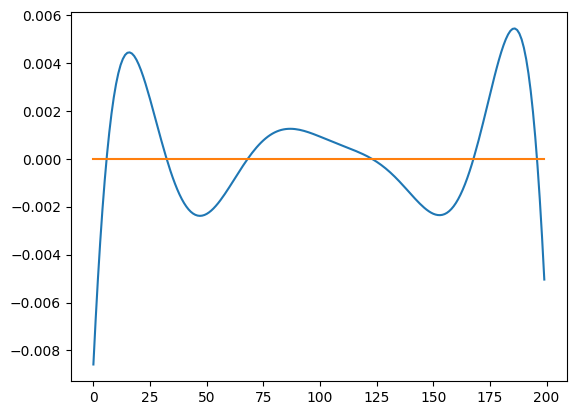

In [8]:
plt.plot(T_PINN[:,0])
plt.plot(T_FVM[:,0])

In [9]:
print("T RMSD",np.sqrt(np.mean(np.square(T_FVM - T_PINN))))
print("C RMSD",np.sqrt(np.mean(np.square(C_FVM - C_PINN))))

T RMSD 0.03573383642224356
C RMSD 0.0182975063372724


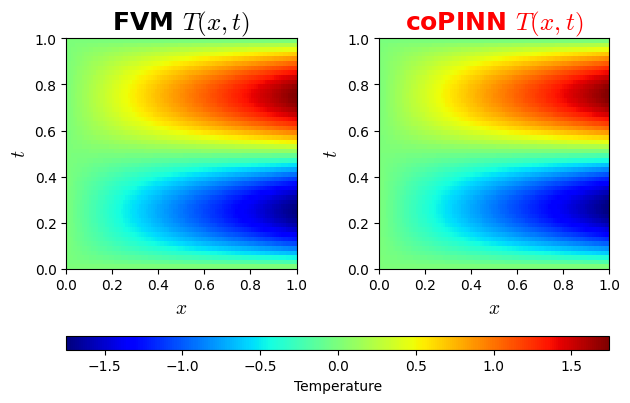

In [12]:
fixed_params = {'xlabel': '$x$','ylabel': '$t$','extent': [0,L,0,t_end],
                'proposed_indicator': 1,'aspect':1}

data = [T_FVM,T_PINN]
title = ['FVM $T(x,t)$','coPINN $T(x,t)$']
colorbar_label = 'Temperature'
save_name = "Temp_1D_Values"
vmax = np.max(T_PINN)
vmin = np.min(T_PINN)


plot_data = {"fixed_params": fixed_params,"data":data,'title':title,"vmax":vmax,"vmin":vmin,
             "colorbar_label":colorbar_label,"save_name":save_name}


save_imshow_sidebyside(plot_data)


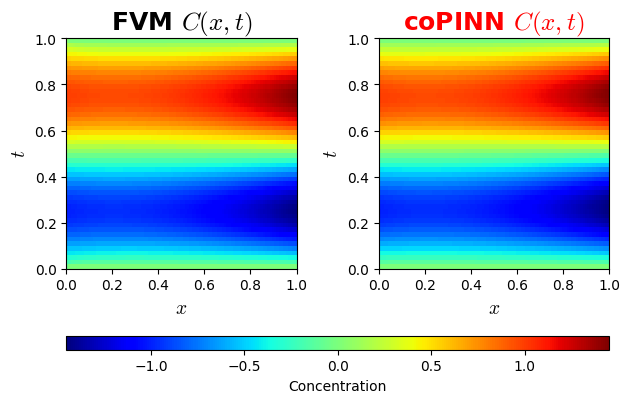

In [13]:
data = [C_FVM,C_PINN]
title = ['FVM $C(x,t)$','coPINN $C(x,t)$']
colorbar_label = 'Concentration'
save_name = "Conc_1D_Values"
vmax = np.max(C_PINN)
vmin = np.min(C_PINN)


plot_data = {"fixed_params": fixed_params,"data":data,'title':title,"vmax":vmax,"vmin":vmin,
             "colorbar_label":colorbar_label,"save_name":save_name}


save_imshow_sidebyside(plot_data)


In [14]:
opt = 'grid'
interp_method = 'spline'

interp_layers = [2,50,50,50,50,1]
interp_device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
interp_max_iter = 5000

NN_constants = {"layers":interp_layers,"device":interp_device,"max_iter":interp_max_iter}



f1_PINN,f1_fvm,f2_PINN,f2_fvm = res_compare(opt,interp_method,pde_related_funcs,problem_constants,
                                            N_x,t_steps,T_FVM,C_FVM,coPINN_trained,device,
                                            NN_interp_constants=NN_constants)

(50, 101)
(50, 101)
(50, 101)
PINN_f1: 0.0018
FVM_f1: 0.0280
PINN_f2: 0.0019
FVM_f2: 0.2480


In [13]:
problem_constants

{'L': 1.0,
 'Max_time': 1,
 'alpha': 0.01,
 'beta': 1.0,
 'gamma': 1.0,
 'D': 0.01,
 'forcing_func_torch': <function __main__.forcing_func_torch(x)>}

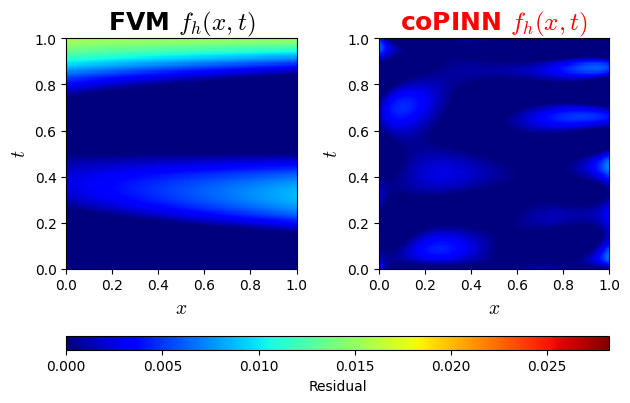

In [16]:
data = [f1_fvm,f1_PINN]
title = ['FVM $f_h(x,t)$','coPINN $f_h(x,t)$']
colorbar_label = 'Residual'
save_name = "Residuals_HeatEquation"
vmax = np.max(np.abs(f1_fvm))
vmin = 0


plot_data = {"fixed_params": fixed_params,"data":data,'title':title,"vmax":vmax,"vmin":vmin,
             "colorbar_label":colorbar_label,"save_name":save_name}


save_imshow_sidebyside(plot_data)

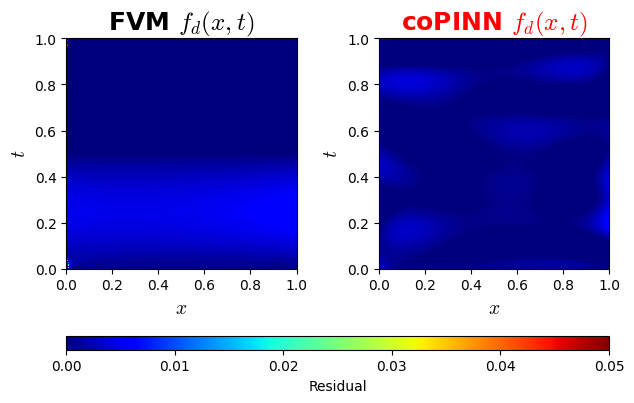

In [17]:
data = [f2_fvm,f2_PINN]
title = ['FVM $f_d(x,t)$','coPINN $f_d(x,t)$']
colorbar_label = 'Residual'
save_name = "Residuals_DiffusionEquation"
# vmax = np.max(np.abs(f2_fvm))
vmax = 0.05
vmin = 0


plot_data = {"fixed_params": fixed_params,"data":data,'title':title,"vmax":vmax,"vmin":vmin,
             "colorbar_label":colorbar_label,"save_name":save_name}


save_imshow_sidebyside(plot_data)

In [14]:
loss_thresh = 25000
level = "_low"
label = "Burgers_coPINN_" 

x = np.linspace(0,1,N_x).reshape(-1,1)
t = np.linspace(0,t_max,t_steps).reshape(-1,1)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))

lb_xt = xt[0]
ub_xt = xt[-1]

NameError: name 't_max' is not defined

In [6]:

pi = torch.from_numpy(np.array(np.pi)).double().to(device)


x = np.linspace(0,1,N_x)
t = np.linspace(0,t_max,t_steps)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))




In [13]:
#CHECKING RESIDUALS AND PLOTTING
#f2 = dC_dt - D*d2C_dx2 - gamma*T



In [14]:
#CHECKING RESIDUALS AND PLOTTING ~  GRID POINTS
f1_PINN,f1_FVM,f2_PINN,f2_FVM = res_compare('grid')

PINN_f1: 0.0019
FVM_f1: 0.0069
PINN_f2: 0.0014
FVM_f2: 0.1048


In [27]:
np.mean(f2_FVM)

5.4337797442834806e-15

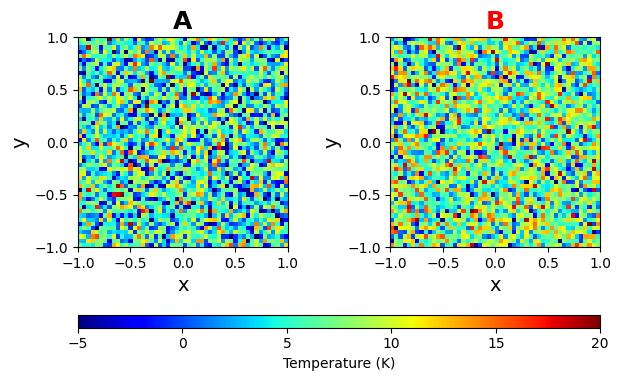

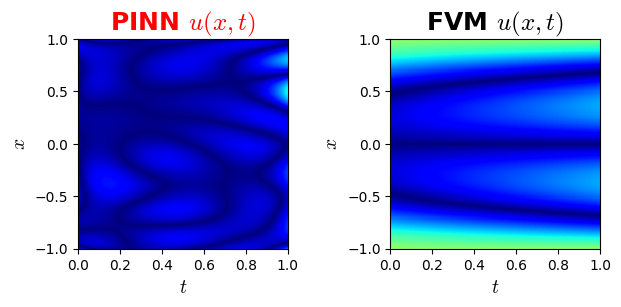

In [20]:
fig, axs = plt.subplots(1,2)
cmap = plt.cm.jet
fig.tight_layout()



ax = axs[0]
img = ax.imshow(np.abs(f1_PINN),interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmin = 0,vmax = 0.03)
ax.set_title('PINN $u(x,t)$',color = 'r',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


ax = axs[1]
img = ax.imshow(np.abs(f1_FVM),interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmin = 0,vmax = 0.03)
ax.set_title('FVM $u(x,t)$',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


fig.tight_layout()
# plt.savefig('Burgers_test_u.svg',format = 'svg')
# plt.savefig('FSU_Burgers_test_u.svg',format = 'svg',bbox_inches = 'tight')

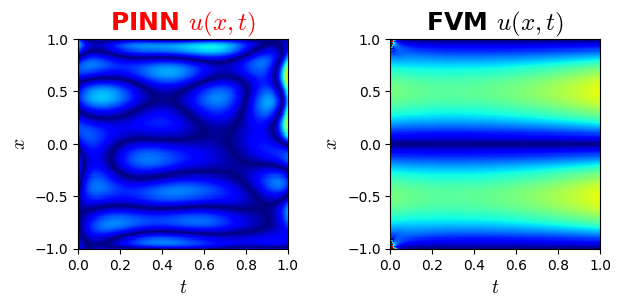

In [31]:
fig, axs = plt.subplots(1,2)
cmap = plt.cm.jet
fig.tight_layout()



ax = axs[0]
img = ax.imshow(np.abs(f2_PINN),interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmin = 0,vmax = 0.01)
ax.set_title('PINN $u(x,t)$',color = 'r',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


ax = axs[1]
img = ax.imshow(np.abs(f2_FVM),interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmin = 0,vmax = 0.01)
ax.set_title('FVM $u(x,t)$',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


fig.tight_layout()

NameError: name 'T_PINN_matrix' is not defined

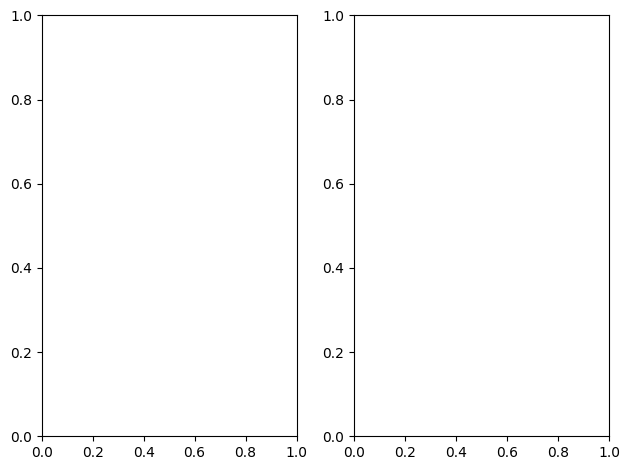

In [16]:
fig, axs = plt.subplots(1,2)
cmap = plt.cm.jet
fig.tight_layout()



ax = axs[0]
img = ax.imshow(T_PINN_matrix,interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmax = 1,vmin = -1)
ax.set_title('PINN $u(x,t)$',color = 'r',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


ax = axs[1]
img = ax.imshow(T_FVM_matrix,interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmax = 1,vmin = -1)
ax.set_title('FVM $u(x,t)$',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


fig.tight_layout()
# plt.savefig('Burgers_test_u.svg',format = 'svg')
# plt.savefig('FSU_Burgers_test_u.svg',format = 'svg',bbox_inches = 'tight')

In [32]:
plt.plot(T_FVM_matrix[:,100],'b')
plt.plot(T_PINN_matrix[:,100],'r')

NameError: name 'T_FVM_matrix' is not defined

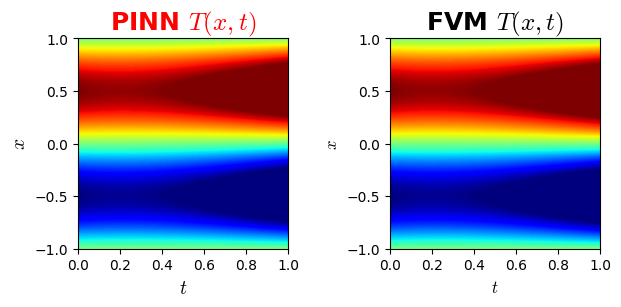

In [81]:
fig, axs = plt.subplots(1,2)
cmap = plt.cm.jet



ax = axs[0]
img = ax.imshow(C_PINN_matrix,cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmax = 1,vmin = -1)
ax.set_title('PINN $T(x,t)$',math_fontfamily = 'cm', color = 'r',fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)
fig.tight_layout()


ax = axs[1]
img = ax.imshow(C_FVM_matrix,cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmax = 1,vmin = -1)
ax.set_title('FVM $T(x,t)$',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 12)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 12)


fig.tight_layout()
# plt.savefig('Burgers_test_T.svg',format = 'svg')
# plt.savefig('FSU_Burgers_test_T.svg',format = 'svg',bbox_inches = 'tight')